In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
(train_image, train_lable), (test_image, test_label) = tf.keras.datasets.mnist.load_data()

##模型架構
    1.編碼器---->均質,標準差
    2.均質,標準差---->隱含變量
    3.解碼器:隱含變量----->重購圖像

數據處理1.規一

In [21]:
train_image=train_image/255

In [22]:
train_image.shape

(60000, 28, 28)

In [23]:
train_image=train_image.reshape(-1,28*28) #####縮減成2維

In [24]:
train_image.shape

(60000, 784)

In [25]:
train_image=train_image.astype(np.float32)

In [26]:
dataset=tf.data.Dataset.from_tensor_slices(train_image) ####轉換成tensor形式

In [27]:
dataset=dataset.shuffle(60000).batch(128)

In [28]:
dataset

<BatchDataset shapes: (None, 784), types: tf.float32>

In [41]:
class VAE_model(tf.keras.Model):
    def __init__(self):
        super(VAE_model, self).__init__()         #####一開始建立需要用到的連接層,tf.keras.layers.....
        self.lin_1 = tf.keras.layers.Dense(400)
        self.lin_2 = tf.keras.layers.Dense(20)
        self.lin_3 = tf.keras.layers.Dense(20)
        self.lin_4 = tf.keras.layers.Dense(400)
        self.lin_5 = tf.keras.layers.Dense(784)
        
    def encode(self, x):                                       
        h1 = tf.nn.relu(self.lin_1(x))                 ####編碼出均質和 log 標準差
        return self.lin_2(h1), self.lin_3(h1)
    
    def reparameters(self, mu, logvar):
        std = tf.math.exp(0.5*logvar)
        eps = tf.random.normal(std.shape, mean=0.0, stddev=1.0)   ######VAE-重參數化
        return mu + eps*std
        
    def decode(self, z):
        h4 = tf.nn.relu(self.lin_4(z))                     ####解碼
        return tf.sigmoid(self.lin_5(h4))
    
    def call(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameters(mu, logvar)
        return self.decode(z), mu, logvar

########定義損失#######

In [42]:
def loss_function(recon_x,x,mu,logvar):
    BCE_loss =tf.keras.losses.binary_crossentropy(x,recon_x)
    KLD_loss=-0.5*tf.reduce_sum(1+logvar-tf.pow(mu,2)-tf.exp(logvar))
    return BCE_loss+0.0001*KLD_loss                                   ######VAE用的損失函數

In [31]:
model=VAE_model()

In [32]:
opt=tf.keras.optimizers.Adam(0.0001)

In [33]:
epoch_loss_avg=tf.keras.metrics.Mean('train_loss')

In [40]:
def train_step(model, images):
    with tf.GradientTape() as t:
        pred_img, mu, logvar = model(images)
        loss_step = loss_function(pred_img, images, mu, logvar)
    grads = t.gradient(loss_step, model.trainable_variables)   #####計算T度###loss和可訓練得參數 計算
    opt.apply_gradients(zip(grads, model.trainable_variables))  ###優化
    epoch_loss_avg(loss_step)                                 ###train loss
    return pred_img

In [35]:
train_loss_results=[]

In [36]:
num_epochs=30

0
Epoch:1: loss: 0.408


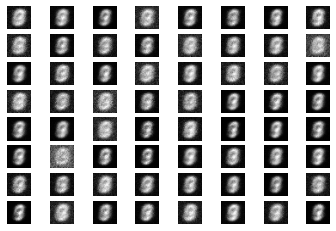

1
Epoch:2: loss: 0.289


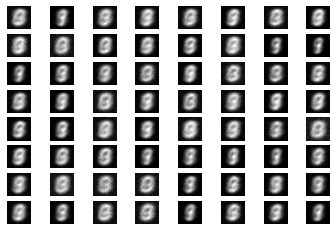

2
Epoch:3: loss: 0.271


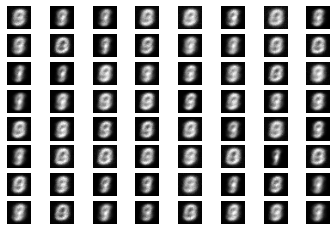

3
Epoch:4: loss: 0.263


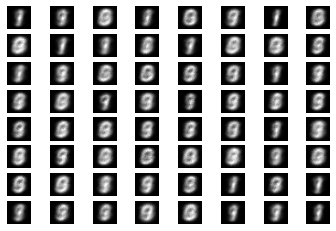

4
Epoch:5: loss: 0.260


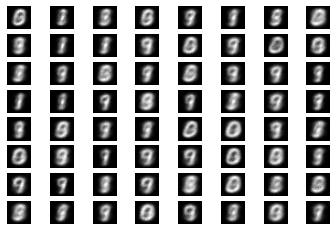

5
Epoch:6: loss: 0.258


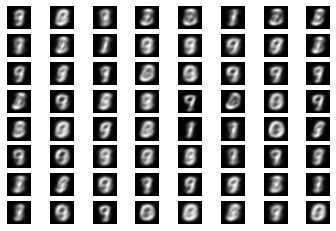

6
Epoch:7: loss: 0.256


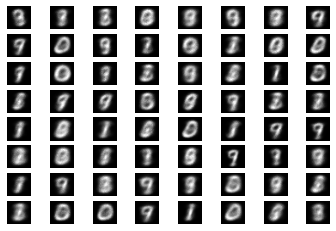

7
Epoch:8: loss: 0.255


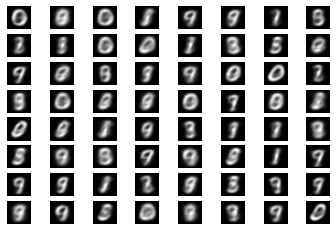

8
Epoch:9: loss: 0.253


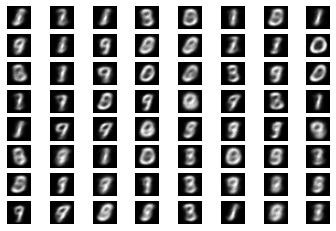

9
Epoch:10: loss: 0.252


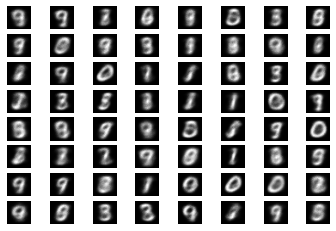

10
Epoch:11: loss: 0.251


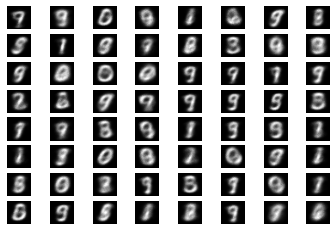

11
Epoch:12: loss: 0.250


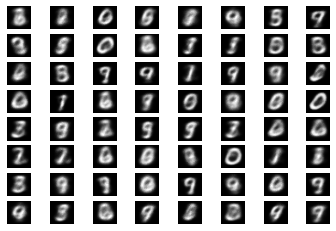

12
Epoch:13: loss: 0.249


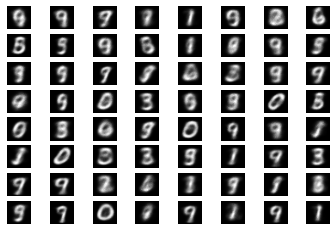

13
Epoch:14: loss: 0.247


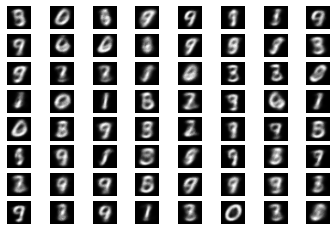

14
Epoch:15: loss: 0.246


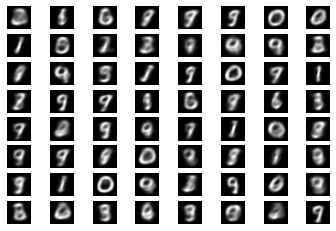

15
Epoch:16: loss: 0.246


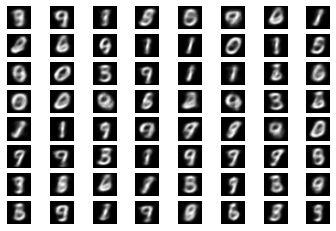

16
Epoch:17: loss: 0.245


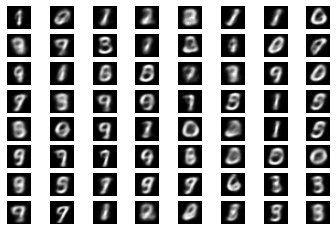

17
Epoch:18: loss: 0.244


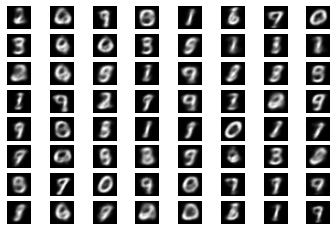

18
Epoch:19: loss: 0.244


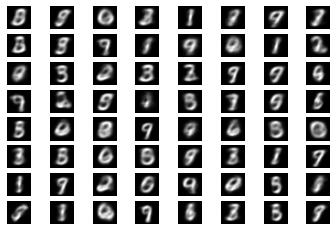

19
Epoch:20: loss: 0.243


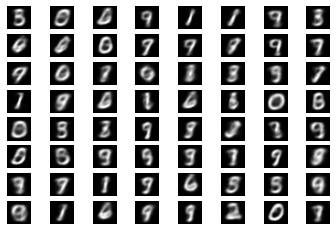

20
Epoch:21: loss: 0.243


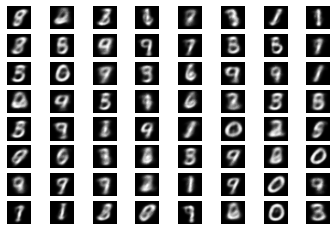

21
Epoch:22: loss: 0.242


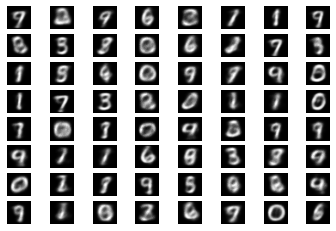

22
Epoch:23: loss: 0.242


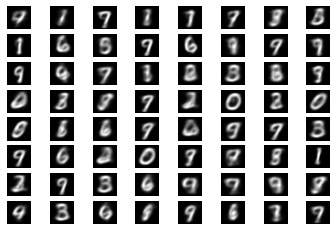

23
Epoch:24: loss: 0.241


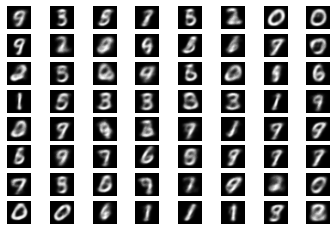

24
Epoch:25: loss: 0.241


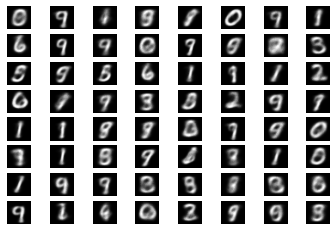

25
Epoch:26: loss: 0.241


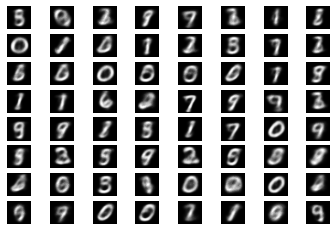

26
Epoch:27: loss: 0.241


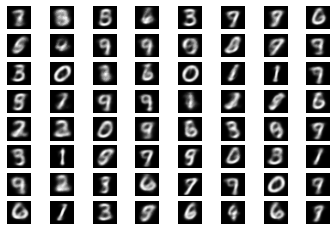

27
Epoch:28: loss: 0.240


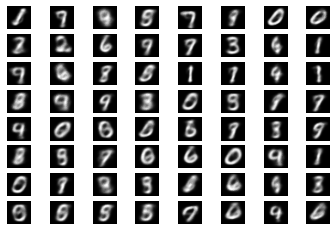

28
Epoch:29: loss: 0.240


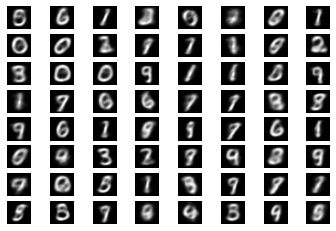

29
Epoch:30: loss: 0.240


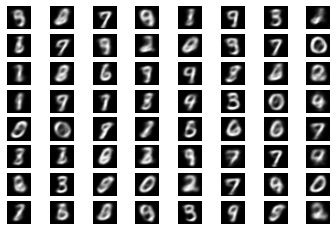

In [39]:
 for epoch in range(num_epochs):
    for imgs in dataset:
        gen_imgs = train_step(model, imgs)
    print(epoch)
    
    train_loss_results.append(epoch_loss_avg.result())
    
    print('Epoch:{}: loss: {:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result()
    ))
    
    epoch_loss_avg.reset_states()
    
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(gen_imgs[i].numpy().reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
    plt.show()

###應用

In [77]:
test_mu=np.linspace(-0.9,0.9,2000).reshape(100,20).astype(np.float32)  ########選20是因為 均質跟標準差都是dense --20
test_logvar=np.linspace(0,3,2000).reshape(100,20).astype(np.float32)

In [76]:
test_mu

array([[-0.9       , -0.8990995 , -0.8981991 , ..., -0.8846924 ,
        -0.8837919 , -0.8828914 ],
       [-0.88199097, -0.8810905 , -0.8801901 , ..., -0.86668336,
        -0.8657829 , -0.86488247],
       [-0.86398196, -0.8630815 , -0.86218107, ..., -0.84867436,
        -0.8477739 , -0.84687346],
       ...,
       [ 0.84687346,  0.8477739 ,  0.84867436, ...,  0.86218107,
         0.8630815 ,  0.86398196],
       [ 0.86488247,  0.8657829 ,  0.86668336, ...,  0.8801901 ,
         0.8810905 ,  0.88199097],
       [ 0.8828914 ,  0.8837919 ,  0.8846924 , ...,  0.8981991 ,
         0.8990995 ,  0.9       ]], dtype=float32)

In [79]:
test_img=model.decode(model.reparameters(test_mu,test_logvar))

In [80]:
test_img.shape

TensorShape([100, 784])

In [81]:
test_img=test_img.numpy().reshape(-1,28,28)

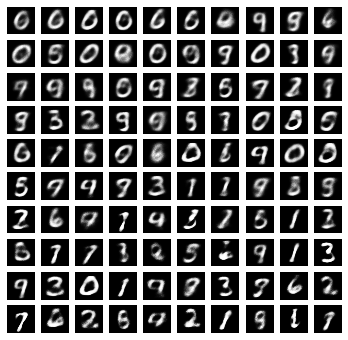

In [82]:
plt.figure(figsize=(6, 6))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(test_img[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')